# Importing the liabraries

In [5]:
# Importing the liabraries
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, accuracy_score,f1_score, classification_report

# Loading and Analysis of Data

In [6]:
df= pd.read_csv('skin_lesions.csv')
df

,image_id,cell_type,is_benign,localization
0,ISIC_0025030,Benign keratosis-like lesions,1.0,scalp
1,ISIC_0025661,Benign keratosis-like lesions,1.0,scalp
2,ISIC_0027850,Benign keratosis-like lesions,1.0,ear
3,ISIC_0025837,Benign keratosis-like lesions,1.0,back
4,ISIC_0025209,Benign keratosis-like lesions,1.0,back
...,...,...,...,...
5365,ISIC_0030965,Melanocytic nevi,1.0,NaN
5366,ISIC_0028490,Benign keratosis-like lesions,1.0,NaN
5367,ISIC_0026722,Melanoma,1.0,NaN
5368,ISIC_0029038,Melanocytic nevi,1.0,NaN


In [8]:
# check for the missing values in the csv
df.isna().sum()

image_id          0
cell_type       100
is_benign       100
localization     13
dtype: int64

In [9]:
# drop the rows with missing values
df = df.dropna()

In [10]:
# again check for missing values
df.isna().sum()

image_id        0
cell_type       0
is_benign       0
localization    0
dtype: int64

1.0    4244
0.0    1013
Name: is_benign, dtype: int64


<AxesSubplot:>

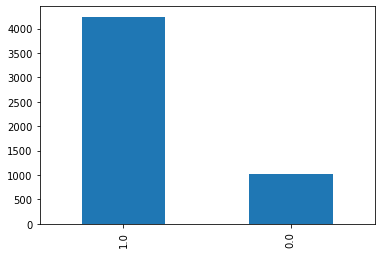

In [11]:
#check the class distribution
print(df['is_benign'].value_counts())
df['is_benign'].value_counts().plot.bar()

#### Observations
- The dataset is imbalanced. 

In [12]:
X=df.drop('is_benign',axis=1)
y= df['is_benign']

# down saple the dataset to balance the data
rus = RandomUnderSampler( )
X_un, y_un = rus.fit_resample(X, y)

print("Before UnderSampling, counts of label '1': {}".format(sum(y_un == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_un == 0)))
print("After UnderSampling, counts of label '1': {}".format(sum(y_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_un == 0)))
print("After UnderSampling, the shape of train_X: {}".format(X_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_un.shape))

Before UnderSampling, counts of label '1': 1013
Before UnderSampling, counts of label '0': 1013 

After UnderSampling, counts of label '1': 1013
After UnderSampling, counts of label '0': 1013 

After UnderSampling, the shape of train_X: (2026, 3)
After UnderSampling, the shape of train_y: (2026,) 



1.0    1013
0.0    1013
Name: is_benign, dtype: int64


<AxesSubplot:>

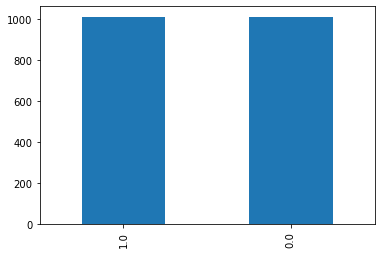

In [9]:
#check the class distribution again
print(y_un.value_counts())
y_un.value_counts().plot.bar()

In [13]:
# There is no missing values 
# now lets load the images

all_data=[]
labels=[]
for i in tqdm (range(len(X_un))):
    path="/Users/priyank_7/Documents/Jupiter/Skinlesions/skin_lesions_images/"+X_un["image_id"][i]+".jpg"
    #print(path)
    img=cv2.imread(path)
    img=cv2.resize(img,(150,150))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=img*(1/255)
    all_data.append(img)
    labels.append(y_un[i])

100%|██████████████████████████████████████| 2026/2026 [00:10<00:00, 189.40it/s]


In [11]:
all_data=np.array(all_data)
labels=np.array(labels)

In [12]:
# print shape, pixel of data

print("Max pixel value = ",all_data.max())
print("Shape of images = ",all_data.shape)
print("Shape of labels = ",labels.shape)

Max pixel value =  1.0
Shape of images =  (2026, 150, 150, 3)
Shape of labels =  (2026,)


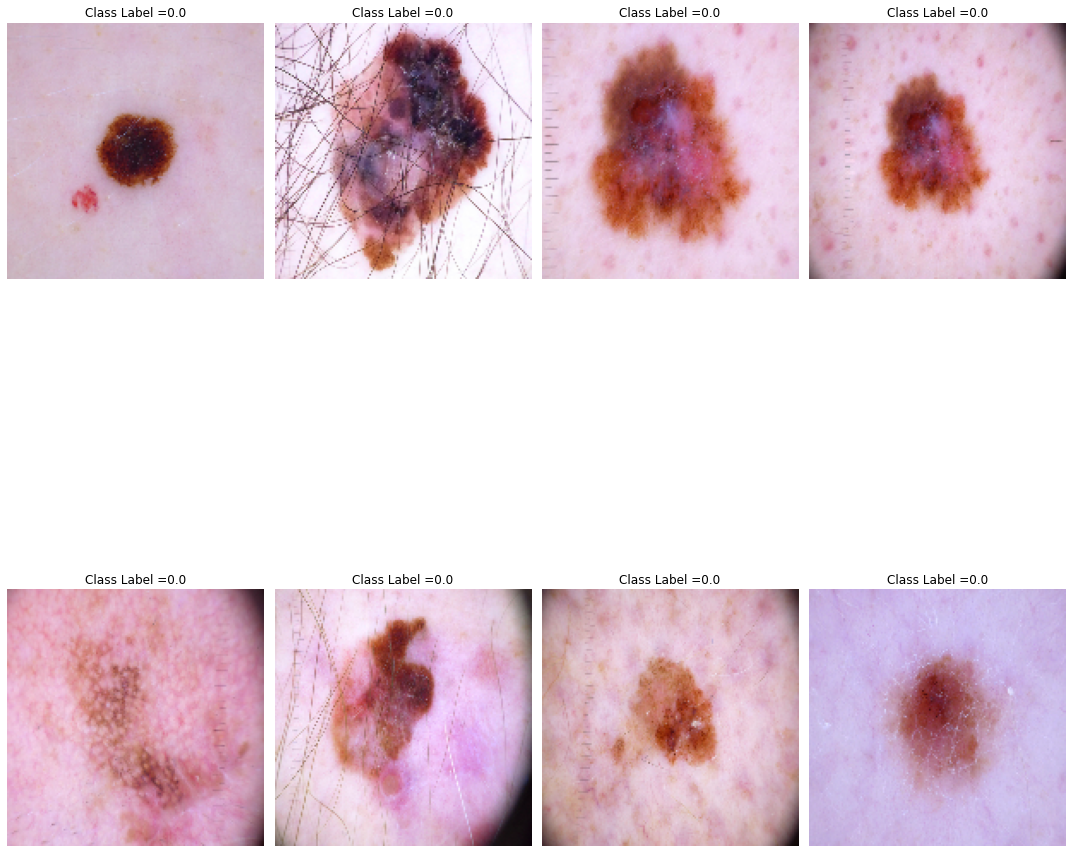

In [13]:
# plot Training images

def plot_images(images_arr,labels):
    fig, axes=plt.subplots(2, 4, figsize=(15,20))
    axes= axes.flatten()
    i=0
    for img , ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        title="Class Label ="+str(labels[i])
        ax.set_title(title)
        i+=1
    plt.tight_layout()
    plt.show()
        
plot_images(all_data[:10],labels[:10])

In [14]:
# Train and valid split

X_train, X_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.3, random_state=42)
del(all_data)
del(labels)

print("Shape of training images = ",X_train.shape)
print("Shape of training labels = ",y_train.shape)
print("Shape of validation images = ",X_test.shape)
print("Shape of validation labels = ",y_test.shape)

Shape of training images =  (1418, 150, 150, 3)
Shape of training labels =  (1418,)
Shape of validation images =  (608, 150, 150, 3)
Shape of validation labels =  (608,)


In [14]:
# plot accuracy, loss curve (graph)
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
accuracy_loss_plot = PlotLearning()

# Model

In [15]:
# import a pretrained VGG16 model for transfer learning
# creating sequential model
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))
vgg.summary()

#transfer_layer = vgg.get_layer('block5_pool')

# Freeze the layer
for layer in vgg.layers:
    layer.trainable = False

#Flatten the output from the 3rd block of the VGG16 model
x = Flatten()(vgg.output) 

# = Dense(256, activation='relu')(x)
# Similarly add a dense layer with 128 neurons
#x = Dropout(0.2)(x)
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.2)(x)
#x = Dense(64, activation='relu')(x)
#x = Dropout(0.2)(x)

x = Dense(64, activation='sigmoid')(x)
#x = Dropout(0.1)(x)
x = Dense(32, activation='sigmoid')(x)
#x = Dropout(0.1)(x)
# Add a dense layer with 64 neurons
#x = BatchNormalization()(x)

pred = Dense(1, activation='sigmoid')(x)

#Initializing the model
model = Model(vgg.input, pred) 
model.summary()


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Metal device set to: Apple M1 Pro
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0


2022-04-26 15:32:25.333550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-26 15:32:25.333768: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost

In [16]:
# complie the model
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=["accuracy"])
#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=["accuracy"])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [17]:
# define call backs
#callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True),accuracy_loss_plot]
# Set a learning rate annealer

callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True),accuracy_loss_plot]

### Training of model

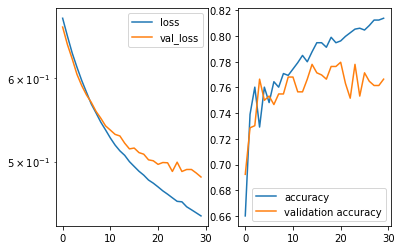

23/23 - 4s - loss: 0.4444 - accuracy: 0.8138 - val_loss: 0.4836 - val_accuracy: 0.7664 - 4s/epoch - 173ms/step


In [19]:

history= model.fit(X_train,y_train, batch_size=64, epochs=30,validation_data=(X_test,y_test), shuffle=True, callbacks = callbacks, verbose = 2)

In [20]:
# check model score
score=model.evaluate(X_test,y_test)
print(score)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Rea

# Performance Evaluation

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

<Figure size 1080x720 with 0 Axes>

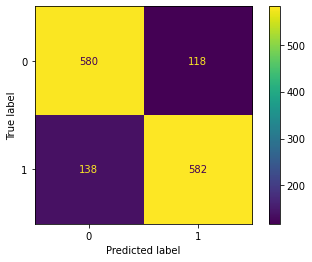

In [21]:
# get predictions on train data
y_predict=model.predict(X_train)


# converting the class labels
for i in range(len(y_predict)):
    if y_predict[i] <= 0.5:
        y_predict[i]=0
    else:
        y_predict[i]=1
        
        
print("Accuracy on train data = ", accuracy_score(y_train,y_predict))
print("F1 score on train data = ",f1_score(y_train,y_predict))


# plot confusion matrix
cm=confusion_matrix(y_train,y_predict)
plt.figure(figsize=(15,10))
ConfusionMatrixDisplay(cm).plot()        


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

<Figure size 1080x720 with 0 Axes>

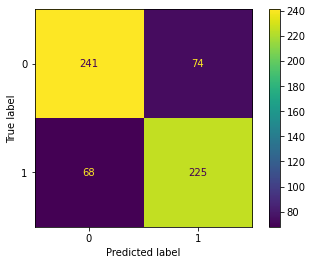

In [22]:
# get predictions on test data
y_predict=model.predict(X_test)

# converting the class labels
for i in range(len(y_predict)):
    if y_predict[i] <= 0.5:
        y_predict[i]=0
    else:
        y_predict[i]=1
                
print("Accuracy on test data = ", accuracy_score(y_test,y_predict))
print("F1 score on test data = ",f1_score(y_test,y_predict))

# plot confusion matrix
cm=confusion_matrix(y_test,y_predict)
plt.figure(figsize=(15,10))
ConfusionMatrixDisplay(cm).plot()        
